In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x =np.linspace(0,50,501)

In [3]:
y = np.sin(x)

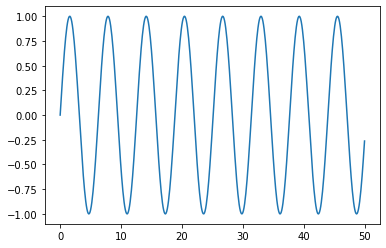

In [4]:
plt.plot(x,y)

In [5]:
df = pd.DataFrame(data=y,index=x,columns=['Sine'])

In [6]:
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [7]:
test_percent=0.1
test_point = np.round(len(df)*test_percent)

In [8]:
test_ind =int(len(df)-test_point)

In [9]:
train = df.iloc[:test_ind]

In [10]:
test = df.iloc[test_ind:]

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler=MinMaxScaler()

In [13]:
scaler.fit(train)

MinMaxScaler()

In [14]:
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
length =50
batch_size =1

generator = TimeseriesGenerator(scaled_train,scaled_train,length = length,batch_size=batch_size)

In [17]:
from tensorflow.keras.models import Sequential

In [18]:
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [19]:
n_features=1

In [20]:
model =Sequential()

model.add(SimpleRNN(50,input_shape=(length,n_features)))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [21]:
model.fit_generator(generator,epochs=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
401/401 [==============================] - 2s 5ms/step - loss: 0.0032
Epoch 2/5
401/401 [==============================] - 2s 5ms/step - loss: 1.2387e-04
Epoch 3/5
401/401 [==============================] - 2s 5ms/step - loss: 3.3515e-04
Epoch 4/5
401/401 [==============================] - 2s 5ms/step - loss: 7.7639e-05
Epoch 5/5
401/401 [==============================] - 2s 5ms/step - loss: 8.0710e-06


In [22]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

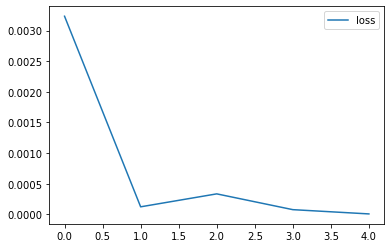

In [23]:
losses.plot()

In [24]:
first_eval_batch = scaled_train[-length:]

In [25]:
first_eval_batch = first_eval_batch.reshape((1,length,n_features))

In [26]:
model.predict(first_eval_batch)

array([[0.94454855]], dtype=float32)

In [27]:
scaled_test[0]

array([0.94955134])

In [28]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch=first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


In [29]:
true_predictions = scaler.inverse_transform(test_predictions)


In [30]:
test['Predictions'] = true_predictions

<ipython-input-30-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:>

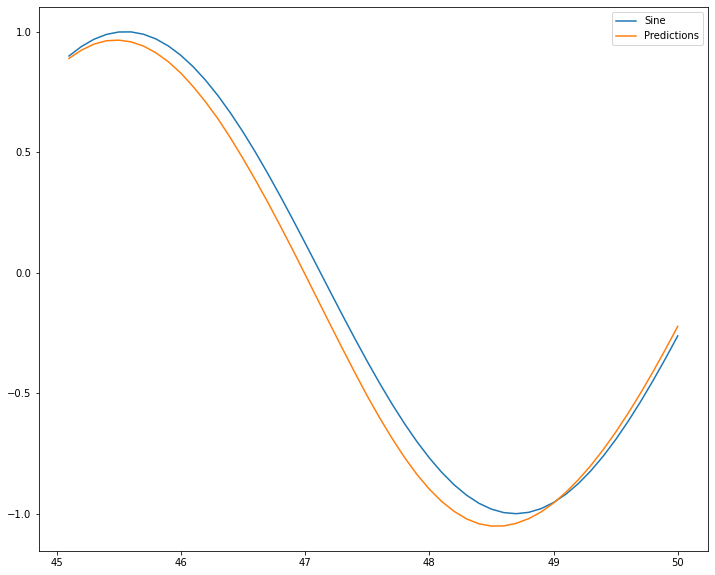

In [31]:
test.plot(figsize=(12,10))

In [32]:
# LSTM

In [33]:
from tensorflow.keras.callbacks import EarlyStopping 

In [34]:
early_stop = EarlyStopping(monitor="val_loss",patience = 2)

In [35]:
length=49
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)
validation_generator =TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [36]:
model =Sequential()

model.add(LSTM(50,input_shape=(length,n_features)))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [37]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
402/402 [==============================] - 5s 11ms/step - loss: 0.0226 - val_loss: 2.7956e-05
Epoch 2/20
402/402 [==============================] - 4s 10ms/step - loss: 5.9317e-05 - val_loss: 5.2112e-05
Epoch 3/20
402/402 [==============================] - 4s 9ms/step - loss: 4.6244e-05 - val_loss: 1.8450e-05
Epoch 4/20
402/402 [==============================] - 4s 9ms/step - loss: 2.1938e-04 - val_loss: 4.7335e-05
Epoch 5/20
402/402 [==============================] - 4s 9ms/step - loss: 4.2271e-05 - val_loss: 2.4957e-06
Epoch 6/20
402/402 [==============================] - 4s 9ms/step - loss: 5.5256e-04 - val_loss: 9.0212e-07
Epoch 7/20
402/402 [==============================] - 4s 10ms/step - loss: 3.0400e-05 - val_loss: 3.6157e-05
Epoch 8/20
402/402 [==============================] - 4s 9ms/step - loss: 2.4277e-05 - val_loss: 3.4505e-06


In [38]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch=first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


<ipython-input-39-5fc512ff806a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions lstm'] = true_predictions


<AxesSubplot:>

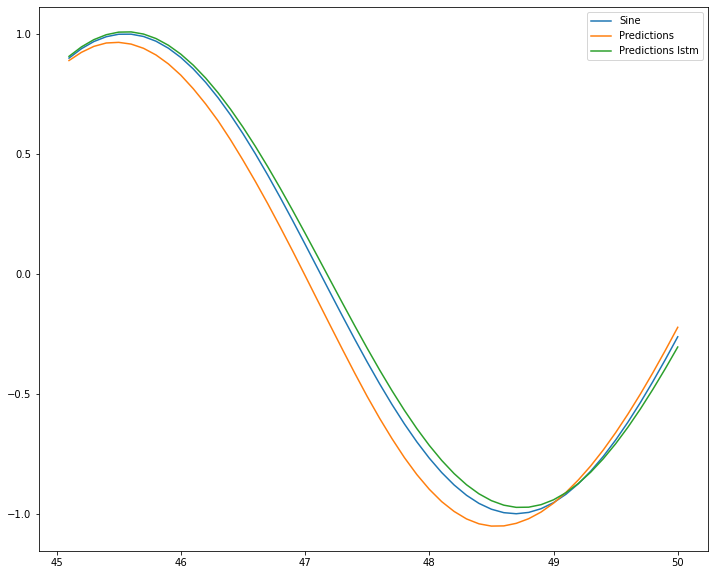

In [39]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions lstm'] = true_predictions
test.plot(figsize=(12,10))